## Import Library & Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
movies_data = pd.read_csv('ml-10m/movies.dat', sep='::', header=None, names=['movieId', 'title', 'genres'], engine='python')
ratings_data = pd.read_csv('ml-10m/ratings.dat', sep='::', header=None, names=['userId', 'movieId', 'rating', 'timestamp'], engine='python')
tags_data = pd.read_csv('ml-10m/tags.dat', sep='::', header=None, names=['userId', 'movieId', 'tag', 'timestamp'], engine='python')

## Data Understanding

Tahapan ini berfokus pada mengetahui unsur-unsur dari data yang telah di-load. Karena isi dari data ini sebagian besar berupa string, maka beberapa hal yang akan dilihat diantaranya yaitu jumlah baris-kolom, tipe data setiap kolom, identifikasi missing value dan lain sebagainya.

In [3]:
print(movies_data.shape)
movies_data.head()

(10681, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings_data.shape)
ratings_data.head()

(10000054, 4)


,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [5]:
print(tags_data.shape)
tags_data.head()

(95580, 4)


,userId,movieId,tag,timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835


#### Penggabungan Dataset

Karena basis data dari MovieLens ini terdiri dari 3 dataset, maka akan dilakukan penggabungan pada 2 dataset saja (tidak termasuk tags_data) 

In [6]:
rating_data_full = pd.merge(movies_data, ratings_data, on='movieId', how='inner')

In [7]:
rating_data_full.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,1.0,857911264
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,3.0,1133572007
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,18,3.0,1111545931
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,23,5.0,849543482
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,24,5.0,868254237


In [8]:
rating_data_full.shape

(10000054, 6)

In [9]:
rating_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000054 entries, 0 to 10000053
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     int64  
 4   rating     float64
 5   timestamp  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 457.8+ MB


Penjelasan detail pada setiap kolommnya

| Kolom       | Tipe Data | Deskripsi                                                                 |
|-------------|-----------|---------------------------------------------------------------------------|
| userId      | Integer   | ID unik untuk pengguna yang memberikan rating                             |
| movieId     | Integer   | ID unik untuk film                                                        |
| rating      | Float     | Nilai rating yang diberikan oleh pengguna untuk film (biasanya 0.5 - 5.0) |
| timestamp   | Integer   | Waktu rating diberikan (format Unix timestamp)                            |
| title       | String    | Judul film beserta tahun rilis                                            |
| genres      | String    | Genre film, dipisahkan dengan tanda `|`                                   |

Penggabungan dataset perlu dilakukan agar langkah-langkah berikutnya tidak menggunakan data yang terpisah, melainkan menggunakan hasil penggabungan data. Selain itu, akan dilakukan konversi pada kolom timestamp (karena format dalam data berupa unix) dan pengambilan tahun rilis film

In [10]:
rating_data_full['timestamp'] = pd.to_datetime(rating_data_full['timestamp'], unit='s')

In [11]:
rating_data_full['year_rating_given'] = rating_data_full['timestamp'].dt.year
rating_data_full['month_rating_given'] = rating_data_full['timestamp'].dt.month

In [12]:
rating_data_full['year_film'] = rating_data_full['title'].str.extract(r'\((\d{4})\)').astype(float)
rating_data_full['title'] = rating_data_full['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

Selain itu, akan dicari tahu nilai unik pada bagian-bagian tertentu

In [13]:
print('Jumlah data film :', len(rating_data_full['movieId'].unique()))
print('Jumlah data pengunjung :', len(rating_data_full['userId'].unique()))
print('Jumlah data penayangan :', len(rating_data_full['userId']))

Jumlah data film : 10677
Jumlah data pengunjung : 69878
Jumlah data penayangan : 10000054


##### Identifikasi missing value, data duplikat

In [14]:
print("Jumlah Missing Value pada setiap kolom: ")
rating_data_full.isna().sum()

Jumlah Missing Value pada setiap kolom: 


movieId               0
title                 0
genres                0
userId                0
rating                0
timestamp             0
year_rating_given     0
month_rating_given    0
year_film             0
dtype: int64

In [15]:
print(f"Jumlah data yang terduplikat: {rating_data_full.duplicated(subset=['title']).sum()}")

Jumlah data yang terduplikat: 9989647


In [16]:
# Hitung duplikat berdasarkan judul
duplicate_counts = rating_data_full['title'].value_counts()
print("Judul film yang paling sering terduplikat:")
print(duplicate_counts.head(20))

Judul film yang paling sering terduplikat:
title
Pulp Fiction                                             34864
Forrest Gump                                             34457
Silence of the Lambs, The                                33668
Jurassic Park                                            32631
Shawshank Redemption, The                                31126
Braveheart                                               29154
Fugitive, The                                            28974
Terminator 2: Judgment Day                               28948
Star Wars: Episode IV - A New Hope (a.k.a. Star Wars)    28566
Batman                                                   27348
Apollo 13                                                27035
Toy Story                                                26449
Independence Day (a.k.a. ID4)                            26042
Dances with Wolves                                       25912
Schindler's List                                         25777
True L

- Tidak terdapat missing value pada hasil gabungan dataset
- Terdapat nama film yang terduplikat (jumlahnya sangat banyak 9989647). Karena banyak judul film yang terduplikat karena efek dari pemberian rating dari beberapa user kepada 1 film tertentu, tindakan berikutnya yang akan dilakukan yaitu mengambil rata-rata rating dari setiap judul film dalam data preparation nantinya dan menaruh hasil penghilangan data yang terduplikat pada variable baru untuk analisa terkait genre

In [17]:
rating_data_full['year_film'] = rating_data_full['year_film'].astype(int)

Selanjutnya yaitu mengekstrak genre yang terdapat dalam film

In [18]:
rating_data_full['genres'] = rating_data_full['genres'].str.replace('|', ' ', regex=False)
rating_data_full['genre_list'] = rating_data_full['genres'].str.split()

genre_long = rating_data_full.explode('genre_list')
genre_real = genre_long.drop_duplicates(subset=['title'])
genre_counts = genre_real['genre_list'].value_counts()

In [19]:
genre_counts

genre_list
Drama          3077
Comedy         2963
Action         1417
Crime           567
Adventure       557
Horror          523
Documentary     434
Children        182
Animation       159
Thriller        126
Western          91
Sci-Fi           71
Romance          58
Mystery          45
Fantasy          45
Musical          44
Film-Noir        26
War              20
IMAX              1
(no               1
Name: count, dtype: int64

In [20]:
rating_data_full.shape

(10000054, 10)

Kemudian menghapus genre yang tidak diketahui

In [21]:
rating_data_full = rating_data_full[~(rating_data_full['genres']=='(no genres listed)')].reset_index(drop=True)

Mengubah nama genre tertentu

In [22]:
rating_data_full['genre_list'] = rating_data_full['genre_list'].apply(
    lambda genres: ['Scifi' if g == 'Sci-Fi' else 'Noir' if g == 'Film-Noir' else g for g in genres]
)

rating_data_full['genres'] = rating_data_full['genre_list'].apply(lambda x: ' '.join(x))

In [23]:
rating_data_full.shape

(10000047, 10)

In [24]:
genre_long = rating_data_full.explode('genre_list')
genre_real = genre_long.drop_duplicates(subset=['title'])
genre_counts = genre_real['genre_list'].value_counts()

#### Visualisasi Distribusi pada Data

Distribusi Rating Pengguna

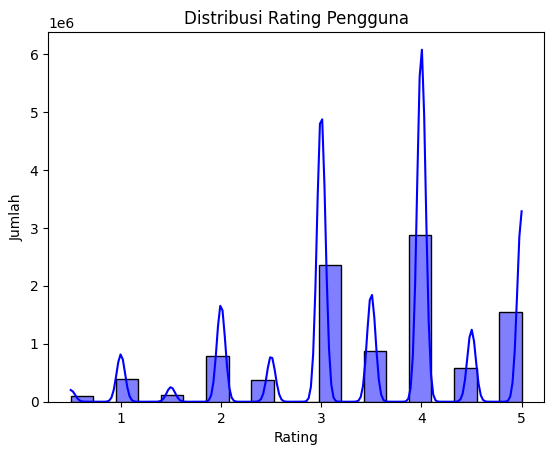

In [25]:
sns.histplot(rating_data_full, x='rating', bins=20, kde=True, color='blue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

Berdasarkan hasil data understanding, terdapat beberapa hal:
- Terdapat beberapa tindakan yang dilakukan pada data, seperti melakukan penggabungan beberapa dataset, mengekstrak tahun dari judul film, mengubah timestamp dari format Unix menjadi datetime, melakukan pembuatan variable baru untuk menampung genre (tanpa data judul film yang terduplikat), dan lain-lain 
- Distribusi rating pengguna memiliki sebaran yang cukup besar pada nilai rating 3-5. Selain itu, hanya sedikit jumlah film yang mendapatkan rating sekitar 1-2.
- Total data untuk rating pada film sekitar 9989647 data (setelah beberapa tindakan). Namun, data tersebut hanya untuk rating. Jika melihat data judul film hanya sekitar 10677, tentunya banyak user yang melakukan pemberian rating pada 1 judul film tertentu.

## Exploratory Data Analysis

Berdasarkan hasil data understanding di bagian sebelumnya, akan dilakukan analisis-analisis untuk mengetahui informasi yang bisa diperoleh dari dataset ini

##### Melihat urutan top 10 pada data

In [26]:
def plot_top_list(data, title_name):
    top_data = data
    colors = ["#33FF57", "#2ECC71", "#27AE60"] + ["#D2D2D2"] * (len(top_data) - 3)

    plt.figure(figsize=(12, 5))
    top_data.plot(kind='barh', color=colors[:len(top_data)])
    plt.title(f'Top 10 {title_name}')
    plt.xlabel('Frekuensi')
    plt.xticks([])
    plt.gca().invert_yaxis()
    plt.tight_layout()

    for index, value in enumerate(top_data):
        plt.text(value + 5, index, str(value), va='center')

    plt.show()

Berdasarkan Genre Film Terbanyak

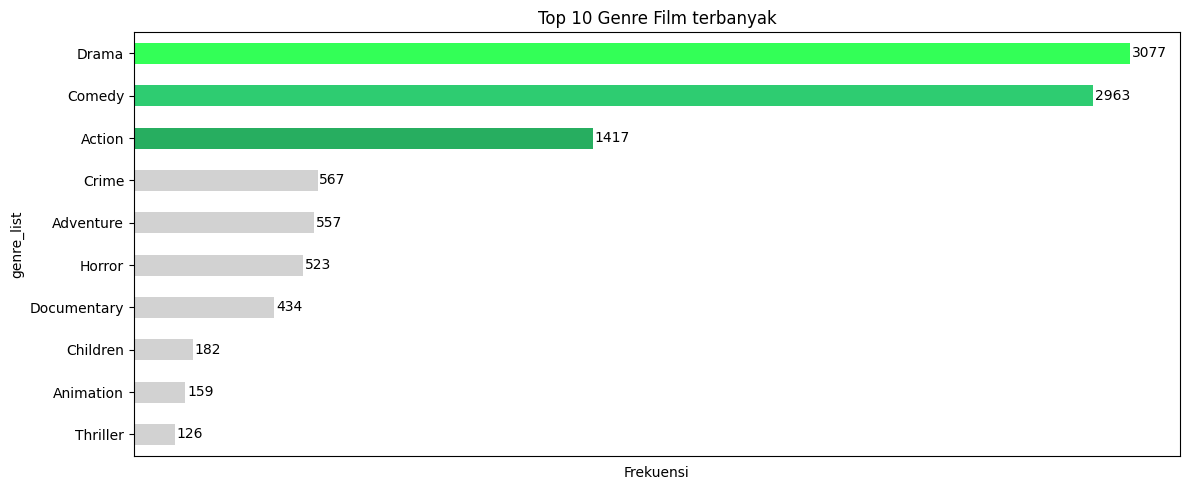

In [28]:
plot_top_list(genre_counts.head(10), 'Genre Film terbanyak')

Berdasarkan pemberian rating terbanyak dalam periode tertentu (tahun dan bulan)

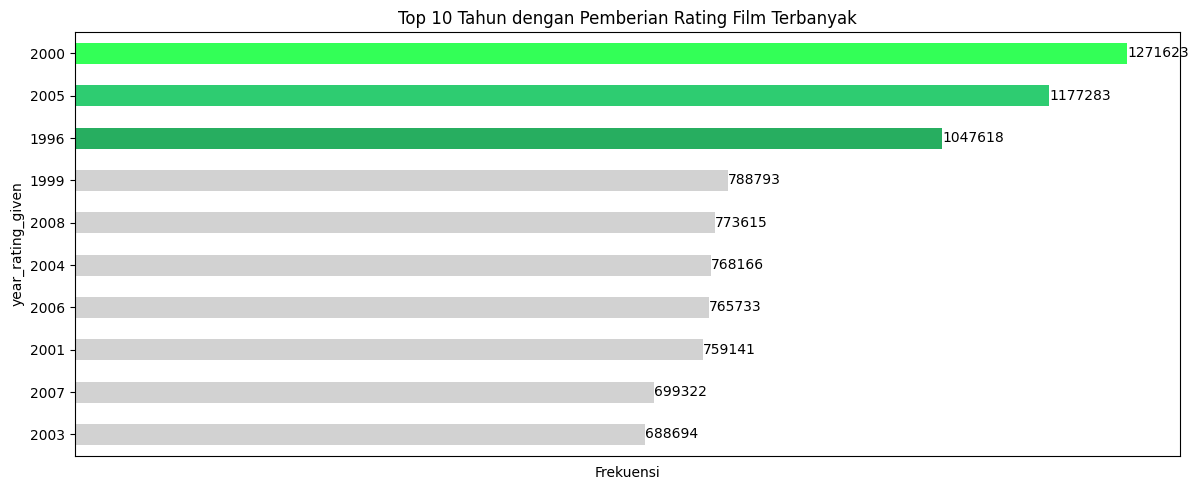

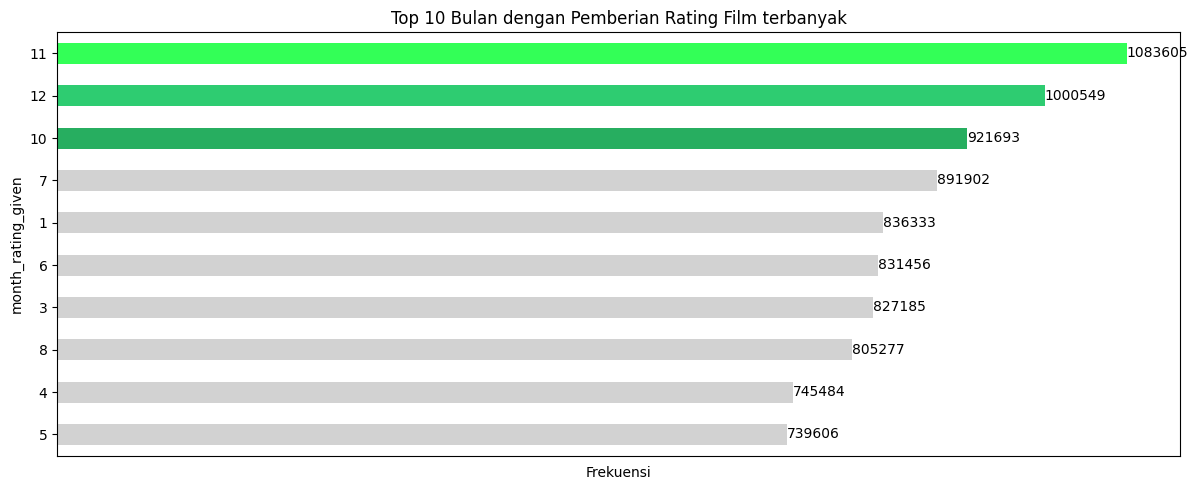

In [29]:
rating_per_year = rating_data_full['year_rating_given'].value_counts().head(10)
rating_per_month = rating_data_full['month_rating_given'].value_counts().head(10)

plot_top_list(rating_per_year.head(10), 'Tahun dengan Pemberian Rating Film Terbanyak')
plot_top_list(rating_per_month.head(10), 'Bulan dengan Pemberian Rating Film terbanyak')

List Film dengan Rating terbanyak dan Rata-rata rating tertinggi

In [27]:
def plot_rating_film(x, y, title_name):
    plt.figure(figsize=(15, 6))
    ax = sns.barplot(x=x, y=y, hue=y, palette='Blues_r')

    for i, v in enumerate(x):
        ax.text(v + 0.01, i, f"{v:.2f}", va='center', fontsize=10)
        
    plt.title(f'{title_name}', fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

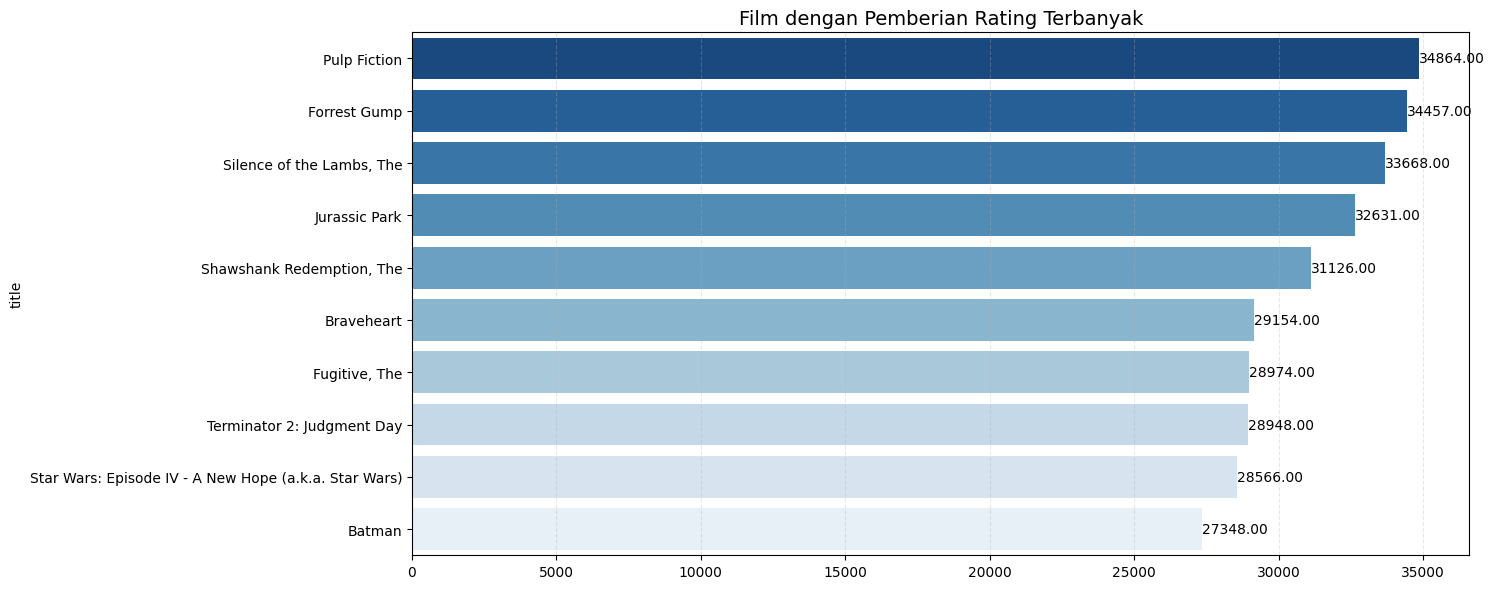

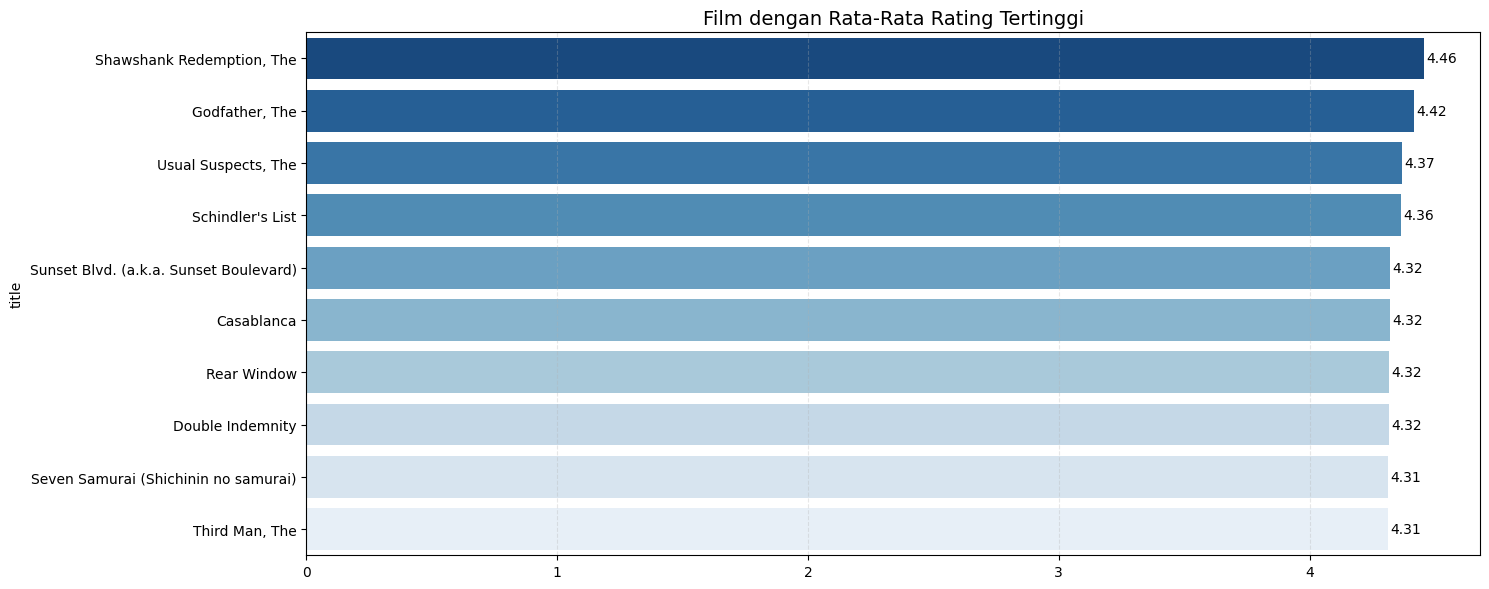

In [28]:
most_rated = rating_data_full.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

film_stats = rating_data_full.groupby('title')['rating'].agg(['mean', 'count'])
film_stats['mean'] = film_stats['mean'].round(3)
popular_films = film_stats[film_stats['count'] >= 50].sort_values('mean', ascending=False).head(10)

plot_rating_film(most_rated.values, most_rated.index, 'Film dengan Pemberian Rating Terbanyak')
plot_rating_film(popular_films['mean'].values, popular_films.index, 'Film dengan Rata-Rata Rating Tertinggi')

Hasil Akhir Analisa pada data:
- 3 Teratas untuk Genre Film yang terdapat dalam dataset dari MovieLens ini yaitu Drama, Comedy, Action. Ini menandakan bahwa pada rentang dataset ini dikumpulkan, genre film yang banyak diminati oleh pasaran yaitu ketiga genre tersebut sehingga banyak produser film yang berupaya untuk mengambil keuntungan dari hal tersebut.
- 3 Teratas untuk Tahun dengan pemberian rating terbanyak yaitu tahun 2000, 2005, dan 1996. Hal ini berarti bahwa dataset ini didominasi oleh film-film yang berada dibawah tahun 2010-an
- 3 teratas untuk Bulan dengan pemberian rating terbanyak yaitu bulan 11, 12, 10. Jika melihat dari bulannya, ini dalam masa-masa akan memasuki liburan akhir tahun, sehingga banyak orang yang mulai meluangkan waktu untuk menonton film dan memberik rating pada website MovieLens.
- 3 Film teratas dengan Pemberian Rating Terbanyak yaitu Pulp Fiction, Forest Gump, The Silence of the Lambs.
- 3 Film dengan rata-rata rating tertinggi yaitu The Shawshank Redemption, The Godfather, The Usual Suspects. Ini menandakan bahwa pemberian rating yang semakin banyak belum tentu sejalan dengan hasil rata-rata rating yang akan selalu tinggi, karena 3 besar ini tidak masuk dalam 3 besar film dengan pemberian rating terbanyak.

## Data Preparation

Beberapa hal akan dilakukan pada bagian ini, seperti:
- Memastikan data yang digunakan sudah memiliki rata-rata rating dari setiap judul film (karena duplikat data akan dihapus)
- Mempersiapkan data untuk Content-Based Filtering
- Mempersiapkan data untuk Collaborative Filtering

In [32]:
rating_data_full.head()

,movieId,title,genres,userId,rating,timestamp,year_rating_given,month_rating_given,year_film,genre_list
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,5,1.0,1997-03-09 12:41:04,1997,3,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,Toy Story,Adventure Animation Children Comedy Fantasy,14,3.0,2005-12-03 01:06:47,2005,12,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
2,1,Toy Story,Adventure Animation Children Comedy Fantasy,18,3.0,2005-03-23 02:45:31,2005,3,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
3,1,Toy Story,Adventure Animation Children Comedy Fantasy,23,5.0,1996-12-02 16:18:02,1996,12,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
4,1,Toy Story,Adventure Animation Children Comedy Fantasy,24,5.0,1997-07-07 05:43:57,1997,7,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"


In [33]:
mean_ratings = film_stats['mean']

rating_data_full['mean_rating'] = rating_data_full['title'].map(mean_ratings)

In [34]:
rating_data_full[rating_data_full['title'] == 'Toy Story'].head(2)

,movieId,title,genres,userId,rating,timestamp,year_rating_given,month_rating_given,year_film,genre_list,mean_rating
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,5,1.0,1997-03-09 12:41:04,1997,3,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",3.929
1,1,Toy Story,Adventure Animation Children Comedy Fantasy,14,3.0,2005-12-03 01:06:47,2005,12,1995,"[Adventure, Animation, Children, Comedy, Fantasy]",3.929


In [35]:
pure_data = rating_data_full.drop_duplicates(subset=['title'])
print(pure_data.shape)

(10406, 11)


#### Persiapan data Content-Based Filtering

Melakukan TF-IDF pada Kolom Genre

In [36]:
tf_idf = TfidfVectorizer(stop_words='english')
tf_idf_matrix = tf_idf.fit_transform(pure_data['genres'])

In [37]:
genre_tfidf_df = pd.DataFrame(tf_idf_matrix.toarray(), columns=tf_idf.get_feature_names_out())
genre_tfidf_df.head()

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,horror,imax,musical,mystery,noir,romance,scifi,thriller,war,western
0,0.0,0.404930,0.555756,0.483633,0.248198,0.0,0.0,0.000000,0.481314,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.510354,0.000000,0.609546,0.000000,0.0,0.0,0.000000,0.606624,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.584570,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.811343,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,0.526521,0.0,0.0,0.434446,0.000000,0.0,0.0,0.0,0.0,0.0,0.730775,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [38]:
genre_tfidf_df.shape

(10406, 19)

In [39]:
print(type(pure_data.index))
print(type(genre_tfidf_df.index))

<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>


In [40]:
pure_data.reset_index(drop=True, inplace=True)

Normalisasi & Penggabungan hasil one-hot encoding pada genre

In [41]:
scaler = MinMaxScaler()
pure_data[["year_film_normalized", "mean_rating_normalized"]] = scaler.fit_transform(pure_data[["year_film", "mean_rating"]])

features = pd.concat([genre_tfidf_df, pure_data[["year_film_normalized", "mean_rating_normalized"]]], axis=1)

C:\Users\hardi\AppData\Local\Temp\ipykernel_872\3538587813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pure_data[["year_film_normalized", "mean_rating_normalized"]] = scaler.fit_transform(pure_data[["year_film", "mean_rating"]])
C:\Users\hardi\AppData\Local\Temp\ipykernel_872\3538587813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pure_data[["year_film_normalized", "mean_rating_normalized"]] = scaler.fit_transform(pure_data[["year_film", "mean_rating"]])


Feature yang digunakan untuk content-based filtering yaitu Genre, Tahun Film Rilis, dan Rata-Rata Rating

In [42]:
features.shape

(10406, 21)

In [43]:
features.isna().sum()

action                    0
adventure                 0
animation                 0
children                  0
comedy                    0
crime                     0
documentary               0
drama                     0
fantasy                   0
horror                    0
imax                      0
musical                   0
mystery                   0
noir                      0
romance                   0
scifi                     0
thriller                  0
war                       0
western                   0
year_film_normalized      0
mean_rating_normalized    0
dtype: int64

##### Persiapan Data untuk Collaborative Filtering

Mengambil fitur-fitur yang diperlukan untuk Collaborative Filtering pada dataset setelah drop_duplicate dilakukan 

In [109]:
get_data = pure_data[['userId', 'movieId', 'rating']].copy()

user_cats  = pure_data['userId'].astype('category').cat.categories
movie_cats = pure_data['movieId'].astype('category').cat.categories

code2user = dict(enumerate(user_cats))
user2code = {v:k for k,v in code2user.items()}  

code2movie = dict(enumerate(movie_cats))
movie2code = {v:k for k,v in code2movie.items()}

get_data['userId'] = get_data['userId'].astype('category').cat.codes  
get_data['movieId'] = get_data['movieId'].astype('category').cat.codes

In [110]:
num_user = get_data['userId'].nunique()
num_movie = get_data['movieId'].nunique()

Mempersiapkan dataset agar bisa sesuai dengan model

In [111]:
def split_dataframe(df, holdout_fraction=0.1):
    test  = df.sample(frac=holdout_fraction, replace=False, random_state=42)
    train = df[~df.index.isin(test.index)]
    return train, test  

def build_rating_sparse_tensor(ratings_df):
    indices = ratings_df[['userId','movieId']].to_numpy()
    values  = ratings_df['rating'].to_numpy(dtype=np.float32)
    return tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=[num_user, num_movie])

In [112]:
train_ratings, test_ratings = split_dataframe(get_data, holdout_fraction=0.15)

global_mean = train_ratings['rating'].mean().astype(np.float32)

In [113]:
A_train = build_rating_sparse_tensor(train_ratings)
A_test  = build_rating_sparse_tensor(test_ratings)

In [114]:
print(f"Num users: {num_user}, Num movies: {num_movie}")
print("Train indices max:", np.max(train_ratings[['userId', 'movieId']].to_numpy(), axis=0))  
print("Test indices max:", np.max(test_ratings[['userId', 'movieId']].to_numpy(), axis=0)) 

Num users: 1531, Num movies: 10406
Train indices max: [ 1530 10405]
Test indices max: [ 1528 10400]


## Modelling Process

Dalam pemodelan untuk sistem rekomendasi dicoba Content-Based Filtering & Collaborative Filtering

#### Content-Based Filtering

In [115]:
model_knn = NearestNeighbors(metric='cosine', n_neighbors=7, n_jobs=-1)
model_knn.fit(features)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=7)

#### Dengan Collaborative Filtering

Dalam collaborative filtering ini, akan dicoba untuk memberikan rekomendasi berdasarkan user dan item

In [123]:
class CFModel:
    def __init__(self, num_users, num_movies, embedding_dim=10, init_stddev=0.1, reg_lambda=1e-4, lr=0.01):
        
        # embedding & bias vars
        self.U = tf.Variable(tf.random.normal([num_users, embedding_dim],
                                              stddev=init_stddev), name='U')
        self.V = tf.Variable(tf.random.normal([num_movies, embedding_dim],
                                              stddev=init_stddev), name='V')
        self.b_u = tf.Variable(tf.zeros([num_users]), name='b_u')
        self.b_i = tf.Variable(tf.zeros([num_movies]), name='b_i')
        self.mu  = tf.constant(global_mean, name='global_mean')
        
        self.reg_lambda = reg_lambda
        self.optimizer  = tf.optimizers.Adam(learning_rate=lr)

    def _mse_and_rmse(self, A_sparse):
        """
        Hitung RMSE pada sparse tensor A_sparse.
        Center prediksi dengan +mu + b_u + b_i.
        """
        # dot-product U[u]·V[i]
        pred_scores = tf.gather_nd(
            tf.matmul(self.U, self.V, transpose_b=True),
            A_sparse.indices
        )
        # ambil bias
        bu = tf.gather(self.b_u, A_sparse.indices[:,0])
        bi = tf.gather(self.b_i, A_sparse.indices[:,1])
        
        # final pred
        preds = self.mu + bu + bi + pred_scores
        errors = A_sparse.values - preds
        mse = tf.reduce_mean(tf.square(errors))
        rmse = tf.sqrt(mse)
        return mse, rmse

    @tf.function
    def train_step(self, A_sparse):
        with tf.GradientTape() as tape:
            mse, _ = self._mse_and_rmse(A_sparse)
            # reg term
            reg = self.reg_lambda * (
                tf.nn.l2_loss(self.U) + tf.nn.l2_loss(self.V)
                + tf.nn.l2_loss(self.b_u) + tf.nn.l2_loss(self.b_i)
            )
            loss = mse + reg
        grads = tape.gradient(loss, [self.U, self.V, self.b_u, self.b_i])
        self.optimizer.apply_gradients(zip(grads, [self.U, self.V, self.b_u, self.b_i]))
        return loss

    def train(self, A_train, A_test, num_iters=100, eval_interval=10, plot=True):
        history = {'train_rmse': [], 'test_rmse': []}

        for it in range(1, num_iters+1):
            self.train_step(A_train)

            if it % eval_interval == 0 or it == num_iters:
                _, train_rmse = self._mse_and_rmse(A_train)
                _, test_rmse  = self._mse_and_rmse(A_test)
                history['train_rmse'].append(train_rmse.numpy())
                history['test_rmse'].append(test_rmse.numpy())
                print(f"\rIter {it:3d} — train_RMSE: {train_rmse:.4f}, "
                      f"test_RMSE: {test_rmse:.4f}", end='')

        print()

        if plot:
            plt.figure(figsize=(8,5))
            plt.plot(history['train_rmse'], label='train RMSE')
            plt.plot(history['test_rmse'],  label='test RMSE')
            plt.xlabel('Evaluation step')
            plt.ylabel('RMSE')
            plt.legend()
            plt.show()

        return history
    
    @property
    def embeddings(self):
        return {
            "userId": self.U.numpy(),
            "movieId": self.V.numpy()
        }

In [126]:
model = CFModel(num_users=num_user, num_movies=num_movie, embedding_dim=5, init_stddev=0.1, reg_lambda=1e-4, lr=0.005)

Iter 2500 — train_RMSE: 0.1209, test_RMSE: 0.9912


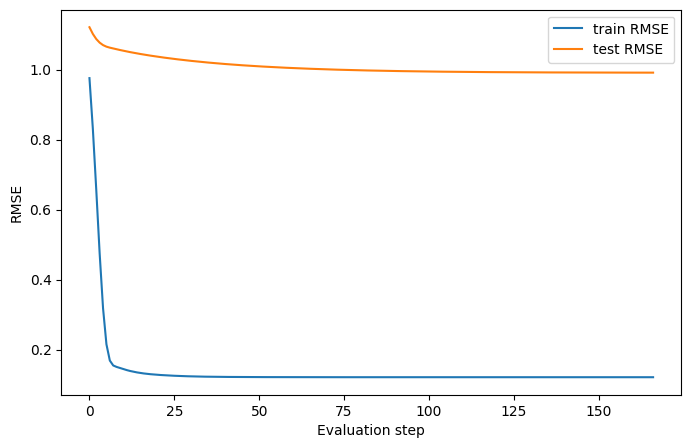

In [127]:
history = model.train(A_train, A_test, num_iters=2500, eval_interval=15, plot=True)

## Evaluation

##### Evaluasi pada hasil Content-Based Filtering

In [91]:
def get_knn_cosine_recommendation(movie_title, df, model, features, n_recommendations=5):
    matches = df[df['title'].str.lower() == movie_title.lower()]
    if matches.empty:
        raise ValueError(f"Film '{movie_title}' tidak ditemukan.")

    movie_index = matches.index[0]
    movie_vector = features.iloc[movie_index].values.reshape(1, -1)
    
    distances, indices = model.kneighbors(movie_vector, n_neighbors=n_recommendations + 1)
    similarities = 1 - distances[0][1:]
    titles = df.iloc[indices[0][1:]]['title'].values
    
    return titles, similarities

In [143]:
titles, scores = get_knn_cosine_recommendation("Toy Story", pure_data, model_knn, features, n_recommendations=10)

df_recs = pd.DataFrame({
    'title': titles,
    'score': scores
})
df_recs = pd.merge(df_recs, pure_data[['title','genres']], on='title', how='inner')

display(df_recs)

c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,title,score,genres
0,Toy Story 2,0.999643,Adventure Animation Children Comedy Fantasy
1,Kiki's Delivery Service (Majo no takkyûbin),0.999366,Adventure Animation Children Comedy Fantasy
2,"Emperor's New Groove, The",0.997915,Adventure Animation Children Comedy Fantasy
3,Antz,0.996694,Adventure Animation Children Comedy Fantasy
4,Shrek the Third,0.989777,Adventure Animation Children Comedy Fantasy
5,"Ant Bully, The",0.988760,Adventure Animation Children Comedy Fantasy
6,Spirited Away (Sen to Chihiro no kamikakushi),0.986443,Adventure Animation Children Fantasy
7,"Cat Returns, The (Neko no ongaeshi)",0.984466,Adventure Animation Children Fantasy
8,Castle in the Sky (Tenkû no shiro Rapyuta),0.984236,Adventure Animation Children Fantasy
9,"Wild, The",0.978569,Adventure Animation Children Comedy Fantasy


  - Untuk rekomendasi pada user yang menonton Toy Story, hasilnya menunjukkan bahwa rekomendasinya memiliki genre yang hampir identik "Adventure Animation Children Comedy Fantasy". Selain itu, judul-judul film berasal dari studio dan gaya yang serupa (misal: Pixar, DreamWorks, Studio Ghibli).
  - Jika melihat nilai Cosine Similarity, nilai kesamaannya sangat tinggi (mendekati 1), sehingga jika melihat juga ke diversitynya, rekomendasi ini kurang beragam namun cocok untuk bisa mempertahankan relevansi.
  - Jika melihat dari sisi Novelty, rekomendasi ini kurang memberikan kebaruan. Cenderung merekomendasikan film yang sudah sangat dikenal user.

##### Evaluasi pada hasil Collaborative Filtering

In [128]:
def safe_normalize(X, axis=1):
    norms = np.linalg.norm(X, axis=axis, keepdims=True)
    return X / (norms + 1e-8)

def compute_scores(u_emb, V, measure='dot'):
    if measure == 'cosine':
        u_emb = u_emb / (np.linalg.norm(u_emb) + 1e-8)
        Vn = safe_normalize(V, axis=1)
        return u_emb.dot(Vn.T)
    else:  # dot
        return u_emb.dot(V.T)

In [129]:
def recommend_for_user(model, raw_user_id, k=6, measure='cosine', 
                       train_df=train_ratings, movies_df=pure_data):

    u_code = user2code.get(raw_user_id)
    if u_code is None:
        raise ValueError(f"User {raw_user_id} not found")

    U = model.U.numpy()
    V = model.V.numpy()

    scores = compute_scores(U[u_code], V, measure)

    rated_codes = train_df.loc[train_df.userId==u_code, 'movieId'].values
    scores[rated_codes] = -np.inf

    topk_codes = np.argpartition(scores, -k)[-k:]
    topk_codes = topk_codes[np.argsort(scores[topk_codes])[::-1]]

    topk_movie_ids = [ code2movie[c] for c in topk_codes ]

    recs = movies_df[movies_df.movieId.isin(topk_movie_ids)].copy()
    recs['score'] = [ scores[c] for c in topk_codes ]

    recs['rank']  = recs['movieId'].map({m:i for i,m in enumerate(topk_movie_ids)})
    return recs.sort_values('rank')[['movieId','title','genres','score']]

In [130]:
def movie_neighbors(model, title_substring, k=6, measure='cosine', movies_df=pure_data):

    candidates = movies_df[movies_df.title.str.contains(title_substring, case=False)]
    if candidates.empty:
        raise ValueError(f"No movie matches “{title_substring}”")
    orig_id  = candidates.iloc[0].movieId
    m_code   = movie2code[orig_id]

    V = model.V.numpy()
    scores = compute_scores(V[m_code], V, measure)
    scores[m_code] = -np.inf

    topk = np.argpartition(scores, -k)[-k:]
    topk = topk[np.argsort(scores[topk])[::-1]]
    topk_ids = [ code2movie[c] for c in topk ]

    neigh = movies_df[movies_df.movieId.isin(topk_ids)].copy()
    neigh['score'] = [ scores[c] for c in topk ]
    neigh['rank']  = neigh['movieId'].map({m:i for i,m in enumerate(topk_ids)})
    return neigh.sort_values('rank')[['movieId','title','genres','score']]

Penerapan rekomendasi data berdasarkan user

In [131]:
user10 = pure_data[pure_data['userId'] == 10]
user10_exploded = user10.explode('genre_list')

genre_counts = user10_exploded['genre_list'].value_counts()
genre_props  = user10_exploded['genre_list'].value_counts(normalize=True)

print("Count per genre:\n", genre_counts, "\n")

Count per genre:
 genre_list
Drama        64
Romance      23
Comedy       15
Crime         6
Mystery       5
Thriller      4
Fantasy       4
War           4
Action        3
Adventure     2
Children      1
Musical       1
Horror        1
Scifi         1
Name: count, dtype: int64 



In [136]:
user_recs = recommend_for_user(model, raw_user_id=10, k=10, measure='cosine')
display(user_recs)

,movieId,title,genres,score
5048,5195,Zombie Lake (Le Lac des morts vivants),Horror,0.999521
10362,64508,Starship Troopers 3: Marauder,Action Scifi War,0.999521
9126,40752,Takeshis',Comedy Drama,0.999521
10405,65133,Blackadder Back & Forth,Comedy,0.999521
9001,34767,My Date with Drew,Comedy Documentary Romance,0.999521
8855,32882,"Big Store, The",Comedy,0.999521
9201,43391,Matti: Hell Is for Heroes (Matti),Comedy Drama,0.999521
10167,61394,"Onion Movie, The",Comedy,0.999521
10299,63458,Critters 4,Comedy Horror Scifi,0.999521
10087,60363,Zombie Strippers!,Comedy Horror,0.999521


  - Untuk rekomendasi berdasarkan preferensi user, diupayakan untuk menyesuaikan hasil rekomendasi dengan kecenderungan genre yang telah ditonton oleh user tertentu. Jika melihat nilai Cosine Similaritynya, hasilnya menunjukkan bahwa sebagian besar rekomendasinya masih sesuai dengan preferensi user,namun beberapa film horror/sci-fi masuk padahal itu bukan preferensi utama user.
  - Jika melihat nilai Novelty, terdapat judul-judul seperti Zombie Lake, Zombie Strippers!, dan The Onion Movie adalah film kurang terkenal di kalangan umum. Sehingga ini bisa untuk merekomendasikan film yang jarang muncul, memberi pengalaman baru.
  - Jika melihat dari sisi Diversity, beberapa film menyertakan kombinasi genre unik (e.g. Comedy Horror, Comedy Documentary Romance), yang menandakan bahwa nilai diversity cukup tinggi. Cocok untuk user yang suka eksplorasi.

Penerapan rekomendasi berdasarkan item (movie)

In [142]:
movie_recs = movie_neighbors(model, "Toy Story", k=10, measure='cosine')
display(movie_recs)

,movieId,title,genres,score
2265,2358,Savior,Drama War,2.153048e-24
1790,1878,Woo,Comedy Romance,2.190811e-24
10114,60735,Shotgun Stories,Drama Thriller,2.032970e-24
8004,8845,No End (Bez konca),Drama,2.150758e-24
9687,53833,David Holzman's Diary,Documentary Drama,2.063623e-24
8819,32389,Deep Crimson (Profundo carmesí),Crime Drama,2.150757e-24
5588,5749,Ghost Story,Drama Horror,2.153047e-24
4427,4561,Waxwork,Comedy Horror,2.153047e-24
1758,1843,Slappy and the Stinkers,Children Comedy,2.230936e-24
6116,6285,Levity,Drama,2.153047e-24


  - Rekomendasi dilakukan berdasarkan preferensi film yang telah ditonton. Jika melihat nilai Cosine Similaritynya, hasilnya menunjukkan bahwa sebagian besar rekomendasinya banyak yang tidak sesuai dengan genre film Toy Story dan nilainya tergolong sangat rendah.
  - Jika melihat nilai Novelty dan Diversity, nampaknya sangat tinggi karena memberikan rekomendasi film yang kurang dikenal pengguna berdasarkan film yang telah ditonton.

Kesimpulan akhir:
- Dengan menggunakan Content-Based Filtering, hasilnya sangat genre-driven dan relevan dengan film asal (misalnya Toy Story → film anak-anak, animasi, dll) yang bisa digunakan untuk tetap menjaga relevasi konten yang ditonton pengguna, tetapi kurang bisa memberikan variasi rekomendasi (novelty dan diversitynya rendah) yang lebih terhadap user.
- Dengan menggunakan Collaborative Filtering, hasilnya dapat menemukan hubungan tersembunyi antar item dan antar user serta bisa merekomendasikan hal di luar genre yang kelihatan. Namun, untuk memberikan rekomendasi berdasarkan film yang telah ditonton, kurang memberikan hasil yang baik meskipun telah memberikan keragaman dalam rekomendasi filmnya
- Content-Based cocok untuk genre match, interpretasi eksplisit, dan ketika kita tahu apa yang mirip. Collaborative Filtering unggul dalam menemukan pola tersembunyi yang tidak bisa dilihat dari metadata saja, serta memberikan novelty dan diversity lebih tinggi.